In [225]:
from data_reader_writer import *
import itertools as it
import pandas as pd
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeCV, ElasticNetCV, SGDClassifier, LinearRegression
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

%matplotlib inline

In [101]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
ephys_data = load_ephys_data()
gamble_choices = load_gamble_choices_data()
behavior_data = load_behavior_data()
regressor_data = load_regressor_data()

In [3]:
gamble_choices.head()

,Safe.Bet.Amount,Risky.Bet.Amount,Risky.bet.shown.number,Risky.bet.hidden.number,Risky.Side
0,10,30,1,5,Left
1,10,20,4,5,Left
2,10,25,7,8,Right
3,10,30,1,4,Left
4,10,25,6,1,Left


In [4]:
sub1_ephys = ephys_data["s1"]
sub1_behavior = behavior_data["s1"]
sub1_behavior.head()

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.location,choice.class,outcome,trial.included
0,1,6.191,6.957,8.003,8.019,8.535,Left,Gamble,Win,1
1,2,9.550,10.316,11.441,11.457,11.972,Left,Gamble,Win,1
2,3,12.988,13.753,14.832,14.847,15.363,Left,Safebet,WouldHaveWon,1
3,4,16.378,17.144,18.144,18.175,18.691,Left,Gamble,Win,1
4,5,19.707,20.472,21.519,21.550,22.066,Right,Safebet,WouldHaveLost,1


In [5]:
df = pd.concat([sub1_behavior, gamble_choices[["Risky.Bet.Amount", "Risky.bet.shown.number"]]], axis=1)
df.head()

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.location,choice.class,outcome,trial.included,Risky.Bet.Amount,Risky.bet.shown.number
0,1,6.191,6.957,8.003,8.019,8.535,Left,Gamble,Win,1,30,1
1,2,9.550,10.316,11.441,11.457,11.972,Left,Gamble,Win,1,20,4
2,3,12.988,13.753,14.832,14.847,15.363,Left,Safebet,WouldHaveWon,1,25,7
3,4,16.378,17.144,18.144,18.175,18.691,Left,Gamble,Win,1,30,1
4,5,19.707,20.472,21.519,21.550,22.066,Right,Safebet,WouldHaveLost,1,25,6


In [6]:
df['choice.class'].value_counts()

Gamble     124
Safebet     72
Timeout      4
Name: choice.class, dtype: int64

In [7]:
X = df[df['choice.class'] != 'Timeout'][['Risky.Bet.Amount', 'Risky.bet.shown.number']]
X.head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,30,1
1,20,4
2,25,7
3,30,1
4,25,6


In [8]:
X.mean()

Risky.Bet.Amount          22.423469
Risky.bet.shown.number     4.831633
dtype: float64

In [9]:
X.max()

Risky.Bet.Amount          30
Risky.bet.shown.number    10
dtype: int64

In [10]:
X.min()

Risky.Bet.Amount          15
Risky.bet.shown.number     0
dtype: int64

In [11]:
(X - X.mean()).head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,7.576531,-3.831633
1,-2.423469,-0.831633
2,2.576531,2.168367
3,7.576531,-3.831633
4,2.576531,1.168367


In [12]:
X.max() - X.min()

Risky.Bet.Amount          15
Risky.bet.shown.number    10
dtype: int64

In [60]:
X_norm = (X - X.mean()) / (X.max() - X.min())
X_norm.head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,0.505102,-0.383163
1,-0.161565,-0.083163
2,0.171769,0.216837
3,0.505102,-0.383163
4,0.171769,0.116837


In [61]:
df = X['Risky.Bet.Amount']
df_norm = (df - df.mean()) / (df.max() - df.min())

In [93]:
regressor_data['s8']['rpe'].flatten()[:10]

array([3., 0., 0., 3., 0., 0., 5., 0., 0., 9.])

In [95]:
behavior_data['s8']['outcome'][:10]

0              Win
1     WouldHaveWon
2     WouldHaveWon
3              Win
4    WouldHaveLost
5     WouldHaveWon
6              Win
7    WouldHaveLost
8    WouldHaveLost
9              Win
Name: outcome, dtype: object

In [96]:
gamble_choices.head(10)

,Safe.Bet.Amount,Risky.Bet.Amount,Risky.bet.shown.number,Risky.bet.hidden.number,Risky.Side
0,10,30,1,5,Left
1,10,20,4,5,Left
2,10,25,7,8,Right
3,10,30,1,4,Left
4,10,25,6,1,Left
5,10,30,1,7,Right
6,10,25,2,5,Right
7,10,20,7,2,Left
8,10,25,9,6,Right
9,10,30,3,8,Left


In [62]:
sub1_behavior[sub1_behavior['choice.class'] == 'Timeout']

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.location,choice.class,outcome,trial.included
11,12,44.832,45.597,NaN,47.613,48.128,Timeout,Timeout,Timeout,0
15,16,60.597,61.363,NaN,63.378,63.894,Timeout,Timeout,Timeout,0
110,111,402.800,403.566,NaN,405.582,406.097,Timeout,Timeout,Timeout,0
156,157,562.253,563.019,NaN,565.035,565.550,Timeout,Timeout,Timeout,0


In [63]:
idx = sub1_behavior[sub1_behavior['choice.class'] == 'Timeout'].index
idx

Int64Index([11, 15, 110, 156], dtype='int64')

In [64]:
sub1_behavior.iloc[idx]

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.location,choice.class,outcome,trial.included
11,12,44.832,45.597,NaN,47.613,48.128,Timeout,Timeout,Timeout,0
15,16,60.597,61.363,NaN,63.378,63.894,Timeout,Timeout,Timeout,0
110,111,402.800,403.566,NaN,405.582,406.097,Timeout,Timeout,Timeout,0
156,157,562.253,563.019,NaN,565.035,565.550,Timeout,Timeout,Timeout,0


In [65]:
def make_data(subjects=SUBJECTS):
    data = {}
    for s in subjects:
        behav = behavior_data[s]
        non_timeout_idx = behav[behav['choice.class'] != 'Timeout'].index
        X = gamble_choices.iloc[non_timeout_idx][['Risky.Bet.Amount', 'Risky.bet.shown.number']]
        y = behav.iloc[non_timeout_idx]['choice.class'].replace('Gamble', 1).replace('Safebet', 0)
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)
        data[s] = (X, y)
    return data

In [66]:
def make_normalized_data(subjects=SUBJECTS):
    data = {}
    for s in subjects:
        behav = behavior_data[s]
        non_timeout_idx = behav[behav['choice.class'] != 'Timeout'].index
        X = gamble_choices.iloc[non_timeout_idx][['Risky.Bet.Amount', 'Risky.bet.shown.number']]
        y = behav.iloc[non_timeout_idx]['choice.class'].replace('Gamble', 1).replace('Safebet', 0)
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)
        X_norm = (X - X.mean()) / (X.max() - X.min()) # normalize data
        data[s] = (X_norm, y)
    return data

In [67]:
def normalize(data):
    return (data - data.mean()) / (data.max() - data.min())

In [68]:
data = make_data()

In [69]:
data_norm = make_normalized_data()

In [70]:
data['s1'][0].head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,30,1
1,20,4
2,25,7
3,30,1
4,25,6


In [71]:
type(sub1_ephys['buttonpress_events_hg']) == np.ndarray

True

In [72]:
data_norm['s1'][0].head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,0.505102,-0.383163
1,-0.161565,-0.083163
2,0.171769,0.216837
3,0.505102,-0.383163
4,0.171769,0.116837


In [73]:
type(data_norm['s1'][0]) == pd.core.frame.DataFrame

True

In [102]:
X, y = data['s9']
logr = LogisticRegression()
print("LogisticRegression", cross_val_score(logr, X, y, cv=5)) 
lasso = LassoCV()
print("LassoCV", cross_val_score(lasso, X, y, cv=5)) 
ridge = RidgeCV()
print("RidgeCV", cross_val_score(ridge, X, y, cv=5)) 
linsvc = LinearSVC()
print("LinearSVC", cross_val_score(linsvc, X, y, cv=5))
nusvc = NuSVC()
print("NuSVC", cross_val_score(nusvc, X, y, cv=5))
svc = SVC()
print("SVC", cross_val_score(svc, X, y, cv=5))
dt = DecisionTreeClassifier()
print("DecisionTreeClassifier", cross_val_score(dt, X, y, cv=5))
edt = ExtraTreeClassifier()
print("ExtraTreeClassifier", cross_val_score(edt, X, y, cv=5))
rf = RandomForestClassifier()
print("RandomForestClassifier", cross_val_score(rf, X, y, cv=5))
enet = ElasticNetCV()
print("ElasticNetCV", cross_val_score(enet, X, y, cv=5))
sgd = SGDClassifier()
print("SGDClassifier", cross_val_score(sgd, X, y, cv=5))

LogisticRegression [0.85  0.75  0.7   0.925 0.85 ]
LassoCV [0.58823906 0.48156191 0.27773411 0.63145393 0.59726858]
RidgeCV [0.58790851 0.4817875  0.27912191 0.63098886 0.59660411]


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

LinearSVC [0.775 0.85  0.75  0.975 0.925]
NuSVC [0.9   0.825 0.7   0.975 0.875]
SVC [0.9   0.825 0.7   0.975 0.875]
DecisionTreeClassifier [0.9  0.8  0.7  0.95 0.85]
ExtraTreeClassifier [0.9  0.8  0.7  0.95 0.85]
RandomForestClassifier [0.9   0.825 0.7   0.975 0.875]
ElasticNetCV [0.58823285 0.48156661 0.27784843 0.63144598 0.59718059]
SGDClassifier [0.875 0.65  0.675 0.55  0.8  ]


In [112]:
for C in np.arange(0.1, 1.1, 0.1):
    for penalty in ['l1', 'l2']:
        logr = LogisticRegression(penalty=penalty, C=C, fit_intercept=False)
        print("LogisticRegression", penalty, round(C, 1), cross_val_score(logr, X, y, cv=5), 
              cross_val_score(logr, X, y, cv=5).mean()) 

LogisticRegression l1 0.1 [0.775 0.75  0.725 0.875 0.85 ] 0.795
LogisticRegression l2 0.1 [0.775 0.75  0.725 0.875 0.85 ] 0.795
LogisticRegression l1 0.2 [0.775 0.75  0.725 0.875 0.85 ] 0.795
LogisticRegression l2 0.2 [0.775 0.75  0.725 0.875 0.85 ] 0.795
LogisticRegression l1 0.3 [0.775 0.75  0.725 0.875 0.85 ] 0.795
LogisticRegression l2 0.3 [0.775 0.75  0.725 0.875 0.85 ] 0.795
LogisticRegression l1 0.4 [0.775 0.75  0.725 0.875 0.85 ] 0.795
LogisticRegression l2 0.4 [0.775 0.75  0.725 0.875 0.85 ] 0.795
LogisticRegression l1 0.5 [0.775 0.75  0.725 0.875 0.85 ] 0.795
LogisticRegression l2 0.5 [0.775 0.75  0.725 0.875 0.85 ] 0.795
LogisticRegression l1 0.6 [0.775 0.75  0.725 0.875 0.85 ] 0.795
LogisticRegression l2 0.6 [0.775 0.75  0.725 0.875 0.85 ] 0.795
LogisticRegression l1 0.7 [0.775 0.75  0.725 0.875 0.85 ] 0.795
LogisticRegression l2 0.7 [0.775 0.75  0.725 0.875 0.85 ] 0.795
LogisticRegression l1 0.8 [0.775 0.75  0.725 0.875 0.85 ] 0.795
LogisticRegression l2 0.8 [0.775 0.75  0

In [133]:
X_norm = normalize(X)
lsvc = LinearSVC(fit_intercept=False).fit(X_norm, y)
print(accuracy_score(lsvc.predict(X_norm), y))
correct = 0
for i in range(len(X_norm)):
    row = X_norm.loc[i]
    a, b = tuple(lsvc.coef_.flatten())
    prod = a * row['Risky.Bet.Amount'] + b * row['Risky.bet.shown.number']
    correct += (y[i] == (prod > 0))

print(correct / len(X_norm))
y.value_counts()

0.845
0.845


0    105
1     95
Name: choice.class, dtype: int64

In [126]:
y[0]

1

In [104]:
svc = SVC(kernel="rbf")
print("SVC", cross_val_score(svc, X, y, cv=5))
svc = SVC(kernel="linear")
print("SVC", cross_val_score(svc, X, y, cv=5))
svc = SVC(kernel="poly")
print("SVC", cross_val_score(svc, X, y, cv=5))
svc = SVC(kernel="sigmoid")
print("SVC", cross_val_score(svc, X, y, cv=5))

SVC [0.9   0.825 0.7   0.975 0.875]
SVC [0.9   0.775 0.7   0.925 0.85 ]
SVC [0.775 0.775 0.7   0.725 0.925]
SVC [0.525 0.525 0.525 0.525 0.525]


In [233]:
LR = "LogisticRegression"
LASSO = "LassoCV"
RIDGE = "RidgeCV"
LSVC = "LinearSVC"
NUSVC = "NuSVC"
SVC_ = "SVC"
ELNET = "ElasticNetCV"
SGD = "SGDClassifier"
MODELS = [LR, LASSO, RIDGE, LSVC, NUSVC, SVC_, ELNET, SGD]

In [22]:
np.array([[1,2], [3,4]]).mean(axis=0)

A = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
b = np.array([1, 2, 3, 4])
kf = KFold(n_splits=4)
for i1, i2 in kf.split(A):
    print(i1, i2)

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


In [31]:
sgd = SGDClassifier()
sgd.fit(X, y)
y_pred = sgd.predict(X)
precision_recall_fscore_support(y, y_pred, average='weighted')

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


(0.8083623693379792, 0.8, 0.7974296205630356, None)

In [227]:
def cross_validation(X, y, model, k=5, C=1.0, fit_intercept=True, kernel="rbf", gamma="auto"):
    test_accuracies = []
    train_accuracies = []
    test_metrics = []
    train_metrics = []
    X_weights = []
    kf = KFold(n_splits=k)
    
    for idx_tr, idx_te in kf.split(X):
        if type(X) == pd.core.frame.DataFrame:
            X_train = X.iloc[idx_tr]
            y_train = y.iloc[idx_tr]

            X_test = X.iloc[idx_te]
            y_test = y.iloc[idx_te]
        elif type(X) == np.ndarray:
            X_train = X[idx_tr]
            y_train = y[idx_tr]

            X_test = X[idx_te]
            y_test = y[idx_te]
        
        if model == LR:
            logr = LogisticRegression(C=C, fit_intercept=fit_intercept)
            logr.fit(X_train, y_train)
            y_test_pred = logr.predict(X_test)
            y_train_pred = logr.predict(X_train)
            X_weights.append(logr.coef_)
        
        elif model == LSVC:
            lsvc = LinearSVC(C=C, fit_intercept=fit_intercept)
            lsvc.fit(X_train, y_train)
            y_test_pred = lsvc.predict(X_test)
            y_train_pred = lsvc.predict(X_train)
            X_weights.append(lsvc.coef_)
            
        elif model == SVC_:
            svc = SVC(C=C, kernel=kernel, gamma=gamma)
            svc.fit(X_train, y_train)
            y_test_pred = svc.predict(X_test)
            y_train_pred = svc.predict(X_train)
            if kernel == "linear":
                X_weights.append(svc.coef_)
        
        test_accuracies.append(accuracy_score(y_test, y_test_pred))
        train_accuracies.append(accuracy_score(y_train, y_train_pred))
        test_metrics.append(precision_recall_fscore_support(y_test, y_test_pred, average='weighted')[:3]) # exclude support
        train_metrics.append(precision_recall_fscore_support(y_train, y_train_pred, average='weighted')[:3])
        
#         elif model == NUSVC:
#             nusvc = NuSVC()
#             nusvc.fit(X_train, y_train)
#             test_accuracies.append(nusvc.score(X_test, y_test))
#             train_accuracies.append(nusvc.score(X_train, y_train))
#             X_weights.append(nusvc.coef_)  # coef_ only available with a linear kernel
    
    mean_test = round(np.array(test_accuracies).mean(), 3)
    mean_train = round(np.array(train_accuracies).mean(), 3)
    # metrics -- 3 floats: precision, recall, f-score
    mean_test_metrics = np.array(test_metrics).mean(axis=0)
    mean_train_metrics = np.array(train_metrics).mean(axis=0)
    
    mean_weights = None if X_weights == [] else np.array(X_weights).mean(axis=0)[0]
    
    return mean_weights, mean_test, mean_train, mean_test_metrics, mean_train_metrics

In [207]:
np.array([(0,1,2), (4,5,6)]).mean(axis=0)

array([2., 3., 4.])

In [228]:
def test_models(data, models, C=1.0, fit_intercept=True):
    results = defaultdict(dict)
    for m in models:
        mean_coefs = []
        test_accs = []
        train_accs = []
        test_fscores = []
        train_fscores = []
        test_precisions = []
        train_precisions = []
        test_recalls = []
        train_recalls = []
        for s in SUBJECTS:
            X, y = data[s]
            print("Subject", s)
            coefs, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, m, C=C, 
                                                                                                   fit_intercept=fit_intercept)
            mean_coefs.append(coefs)
            test_accs.append(mean_test)
            train_accs.append(mean_train)
            test_precisions.append(mean_test_metrics[0])
            train_precisions.append(mean_train_metrics[0])
            test_recalls.append(mean_test_metrics[1])
            train_recalls.append(mean_train_metrics[1])
            test_fscores.append(mean_test_metrics[2])
            train_fscores.append(mean_train_metrics[2])
            
            print("Model %s, mean test acc %f, train acc %f, mean test f-score %f, train f-score %f" % 
                  (m, mean_test, mean_train, mean_test_metrics[2], mean_train_metrics[2]))
            
        results[m]["mean_coefs"] = mean_coefs
        results[m]["test_accs"] = test_accs
        results[m]["train_accs"] = train_accs
        results[m]["test_f-scores"] = test_fscores
        results[m]["train_f-scores"] = train_fscores
        results[m]["test_precisions"] = test_precisions
        results[m]["train_precisions"] = train_precisions
        results[m]["test_recalls"] = test_recalls
        results[m]["train_recalls"] = train_recalls

    return results

In [230]:
results = test_models(data, [LR, LSVC], C=0.5, fit_intercept=False)

Subject s1
Model LogisticRegression, mean test acc 0.751000, train acc 0.767000, mean test f-score 0.747722, train f-score 0.765737
Subject s2
Model LogisticRegression, mean test acc 0.818000, train acc 0.833000, mean test f-score 0.817414, train f-score 0.833882
Subject s3
Model LogisticRegression, mean test acc 0.660000, train acc 0.650000, mean test f-score 0.656287, train f-score 0.646215
Subject s4


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

Model LogisticRegression, mean test acc 0.353000, train acc 0.547000, mean test f-score 0.296195, train f-score 0.480091
Subject s5
Model LogisticRegression, mean test acc 0.679000, train acc 0.740000, mean test f-score 0.597234, train f-score 0.658779
Subject s6
Model LogisticRegression, mean test acc 0.765000, train acc 0.771000, mean test f-score 0.764054, train f-score 0.772336
Subject s7
Model LogisticRegression, mean test acc 0.850000, train acc 0.849000, mean test f-score 0.847159, train f-score 0.847896
Subject s8
Model LogisticRegression, mean test acc 0.670000, train acc 0.680000, mean test f-score 0.672258, train f-score 0.676679
Subject s9
Model LogisticRegression, mean test acc 0.800000, train acc 0.813000, mean test f-score 0.794853, train f-score 0.811183
Subject s10


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

Model LogisticRegression, mean test acc 0.515000, train acc 0.571000, mean test f-score 0.403112, train f-score 0.469178
Subject s1


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model LinearSVC, mean test acc 0.760000, train acc 0.756000, mean test f-score 0.757288, train f-score 0.753751
Subject s2
Model LinearSVC, mean test acc 0.808000, train acc 0.849000, mean test f-score 0.807312, train f-score 0.848061
Subject s3


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

Model LinearSVC, mean test acc 0.685000, train acc 0.639000, mean test f-score 0.679246, train f-score 0.631214
Subject s4


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: Convergen

Model LinearSVC, mean test acc 0.517000, train acc 0.541000, mean test f-score 0.403475, train f-score 0.423967
Subject s5


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\si

Model LinearSVC, mean test acc 0.724000, train acc 0.730000, mean test f-score 0.636486, train f-score 0.636270
Subject s6


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

Model LinearSVC, mean test acc 0.790000, train acc 0.790000, mean test f-score 0.787605, train f-score 0.788854
Subject s7


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model LinearSVC, mean test acc 0.855000, train acc 0.851000, mean test f-score 0.852452, train f-score 0.850841
Subject s8


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

Model LinearSVC, mean test acc 0.575000, train acc 0.656000, mean test f-score 0.559272, train f-score 0.630726
Subject s9


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model LinearSVC, mean test acc 0.820000, train acc 0.809000, mean test f-score 0.815817, train f-score 0.806790
Subject s10
Model LinearSVC, mean test acc 0.537000, train acc 0.549000, mean test f-score 0.413503, train f-score 0.429931


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:

In [210]:
results_norm = test_models(data_norm, [LR, LSVC], C=0.5, fit_intercept=False)

Subject s1
Model LogisticRegression, mean test acc 0.709000, train acc 0.731000, mean test f-score 0.712878, train f-score 0.735406
Subject s2
Model LogisticRegression, mean test acc 0.889000, train acc 0.888000, mean test f-score 0.889449, train f-score 0.887931
Subject s3
Model LogisticRegression, mean test acc 0.720000, train acc 0.718000, mean test f-score 0.720356, train f-score 0.717371
Subject s4
Model LogisticRegression, mean test acc 0.485000, train acc 0.513000, mean test f-score 0.496644, train f-score 0.514283
Subject s5
Model LogisticRegression, mean test acc 0.588000, train acc 0.577000, mean test f-score 0.617488, train f-score 0.601277
Subject s6
Model LogisticRegression, mean test acc 0.865000, train acc 0.865000, mean test f-score 0.866559, train f-score 0.865860
Subject s7
Model LogisticRegression, mean test acc 0.895000, train acc 0.895000, mean test f-score 0.894536, train f-score 0.894895
Subject s8
Model LogisticRegression, mean test acc 0.700000, train acc 0.709

In [141]:
# metric -- 'accs', 'precisions', 'recalls', 'f-scores'
def plot_model_metrics(results, metric="accs", plot_title=None):
    rows = round(len(results) / 2)
    fig, axes = plt.subplots(rows, 2, figsize=(10, 3 * rows))
    axes = axes.flatten()
    
    models = list(results.keys())
    test_key = "test_" + metric
    train_key = "train_" + metric
    ylabel = metric[:-1] if metric != "accs" else "accuracy"
    title = metric if metric != "accs" else "accuracies"
    for i in range(len(results)):
        m = models[i] # model name
        data = pd.DataFrame({"subject": SUBJECTS + SUBJECTS, "metric": results[m][test_key] + results[m][train_key], 
                                 "type": np.append(np.repeat("test", len(SUBJECTS)), np.repeat("train", len(SUBJECTS)))})
        sns.pointplot(x="subject", y="metric", hue="type", data=data, dodge=True, ax=axes[i]).set(
            title=m + " " + title, ylabel=ylabel)
    
    if plot_title != None:
        save_fig(fig, plot_title)

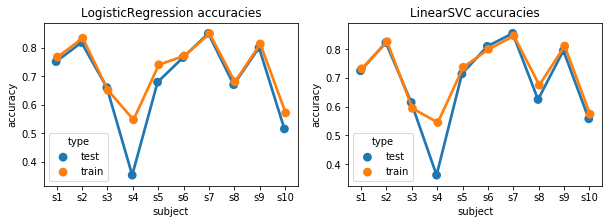

In [211]:
plot_model_metrics(results, plot_title="LR_LSVC_accs_2")

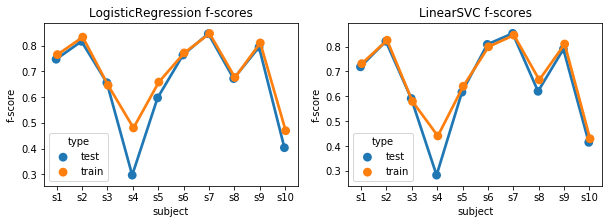

In [212]:
plot_model_metrics(results, metric="f-scores", plot_title="LR_LSVC_fscores_2")

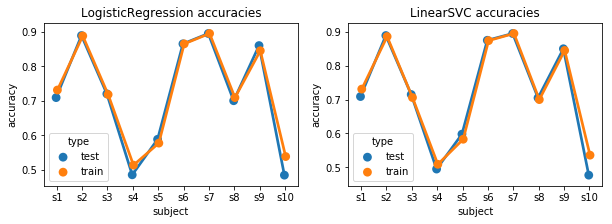

In [213]:
plot_model_metrics(results_norm, plot_title="LR_LSVC_accs_norm_2")

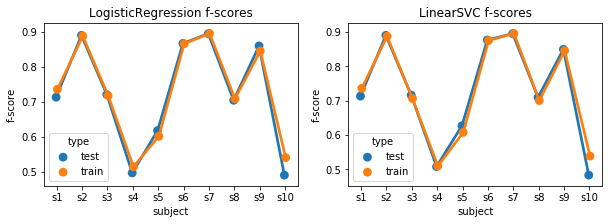

In [214]:
plot_model_metrics(results_norm, metric="f-scores", plot_title="LR_LSVC_fscores_norm_2")

In [215]:
def plot_model_coefs(results, plot_title=None):
    rows = round(len(results) / 2)
    fig, axes = plt.subplots(rows, 2, figsize=(10, 3 * rows))
    axes = axes.flatten()
    
    models = list(results.keys())
    for i in range(len(results)):
        m = models[i] # model name

        data = pd.DataFrame({"prize_coef": np.array(results[m]["mean_coefs"])[:, 0],
                                "rnd_nr_coef": np.array(results[m]["mean_coefs"])[:, 1], 
                                "subject": SUBJECTS}) 
        sns.scatterplot(x="prize_coef", y="rnd_nr_coef", hue="subject", data=data, ax=axes[i]).set(
            title="%s coefs" % m)

        # Show only one legend 
        if i < len(results) - 1:
            axes[i].legend().remove()
        else:
            axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if plot_title != None:
        save_fig(fig, plot_title)

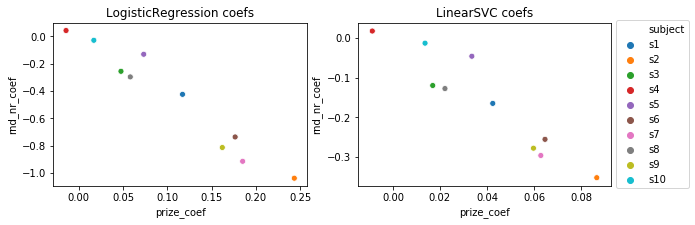

In [216]:
plot_model_coefs(results, "LR_LSVC_coefs_2")

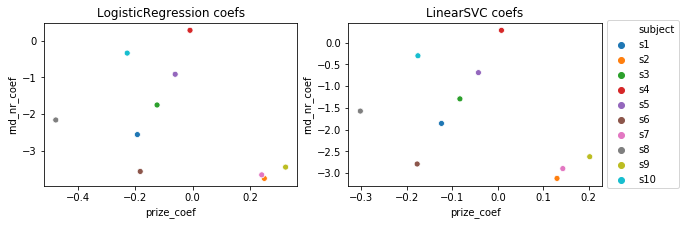

In [217]:
plot_model_coefs(results_norm, "LR_LSVC_coefs_norm_2")

In [27]:
def calculate_winnings():
    winnings = defaultdict(int) # keys: s1, ..., s10, perfect (picked the best option all the time), expected (picked so that
    # expected value = prize * win probability > 0.5 * 18 = 9)
    avg_per_trial = defaultdict(float) # same keys
    
    for i in range(200):
        prize = gamble_choices.iloc[i]['Risky.Bet.Amount']
            
        for s in SUBJECTS:
            if i < len(behavior_data[s]) and behavior_data[s].iloc[i]['trial.included'] == 1:
                outcome = behavior_data[s].iloc[i]['outcome']
                if outcome == 'Win':
                    winnings[s] += prize
                elif outcome == 'WouldHaveWon' or outcome == 'WouldHaveLost':
                    winnings[s] += 10
                
                # First, let's store counts in there
                avg_per_trial[s] += 1
        
        winnings['perfect'] += prize
    
    for s in SUBJECTS:
        avg_per_trial[s] = round(winnings[s] / avg_per_trial[s], 2)
    
    avg_per_trial['perfect'] = round(winnings['perfect'] / 200, 2)
    return winnings, avg_per_trial

calculate_winnings()

(defaultdict(int,
             {'s1': 2400,
              's3': 2405,
              's6': 2600,
              's7': 2485,
              's8': 2475,
              's9': 2760,
              's10': 1475,
              'perfect': 4465,
              's2': 2625,
              's5': 2230,
              's4': 1090}),
 defaultdict(float,
             {'s1': 13.33,
              's3': 12.4,
              's6': 13.9,
              's7': 13.73,
              's8': 12.38,
              's9': 13.8,
              's10': 10.85,
              's2': 13.96,
              's5': 12.46,
              's4': 10.09,
              'perfect': 22.32}))

In [59]:
regressor_data['s8']['risk'].flatten()[:10]

array([0.09, 0.24, 0.21, 0.09, 0.24, 0.09, 0.16, 0.21, 0.09, 0.21])

In [58]:
gamble_choices.head(10)#['Risky.bet.hidden.number'].var()

,Safe.Bet.Amount,Risky.Bet.Amount,Risky.bet.shown.number,Risky.bet.hidden.number,Risky.Side
0,10,30,1,5,Left
1,10,20,4,5,Left
2,10,25,7,8,Right
3,10,30,1,4,Left
4,10,25,6,1,Left
5,10,30,1,7,Right
6,10,25,2,5,Right
7,10,20,7,2,Left
8,10,25,9,6,Right
9,10,30,3,8,Left


In [ ]:
def calculate_expected_winnings():
    winnings = defaultdict(int) 
    
    exp_vals = []
    avg_per_trial = defaultdict(float) # same keys
    exp_val_limit = 0.5 * 18
    unexpected = 0
    unexpected_loss = 0
    
    for i in range(200):
        prize = gamble_choices.iloc[i]['Risky.Bet.Amount']
        risky_nr_1 = gamble_choices.iloc[i]['Risky.bet.shown.number']
        risky_nr_2 = gamble_choices.iloc[i]['Risky.bet.hidden.number']
        win_prob = (10 - risky_nr_1) / 10
        exp_val = prize * win_prob
        will_gamble = exp_val > exp_val_limit
        expected_result = None
        if risky_nr_2 > risky_nr_1 and will_gamble:
            winnings['expected'] += prize
        elif not will_gamble:
            winnings['expected'] += 10
        
        if risky_nr_2 < risky_nr_1 and will_gamble or risky_nr_2 > risky_nr_1 and not will_gamble:
            unexpected += 1
            unexpected_loss += prize if risky_nr_2 > risky_nr_1 else 10

    avg_per_trial['expected'] = round(winnings['expected'] / 200, 2)
    print("Unexpected: %d, loss: %d" % (unexpected, unexpected_loss))
    
    return winnings, avg_per_trial
    

In [21]:
gamble_choices.min()

Safe.Bet.Amount              10
Risky.Bet.Amount             15
Risky.bet.shown.number        0
Risky.bet.hidden.number       0
Risky.Side                 Left
dtype: object

In [150]:
all_datasets = load_var("all_datasets_2")

In [151]:
regressor_data['s9']['gamble_ind'].flatten()#[[1, 3, 5]]

array([1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0], dtype=uint8)

In [152]:
dataset_1 = all_datasets[('s9', GAMEPRES_BUTTONPRESS, ALL, 2, True)]
y1 = regressor_data['s9']['gamble_ind'].flatten()

In [153]:
logr = LogisticRegression(solver="liblinear")
print("LogisticRegression", np.array(cross_val_score(logr, normalize(dataset_1), y1, cv=5)).mean()) 

LogisticRegression 0.5199999999999999


In [154]:
y2 = regressor_data['s9']['winprob'].flatten()

In [155]:
# linreg = LinearRegression()
svr = LinearSVR()
print(np.array(cross_val_score(svr, normalize(dataset_1), y2, cv=5)).mean())

-0.1355661391783453


In [234]:
regression_results = defaultdict(lambda: defaultdict(dict))

for key in all_datasets:
    s, tw_type, trial_type, _, _ = key
    
    s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
    s_behav = s_behav.reset_index(drop=True)
    
    indices = None
    if trial_type == ALL:
        indices = s_behav.index
    else:
        continue
        
    assert len(indices) == len(all_datasets[key]), "Lengths do not correspond!"
    
    X = normalize(all_datasets[key])
    if tw_type == GAMEPRES_BUTTONPRESS:
#         for regr in ["exputil", "risk", "winprob"]:
#             y = regressor_data[s][regr].flatten()[indices]
#             linreg = LinearRegression()
#             score = np.array(cross_val_score(linreg, X, y, cv=5)).mean()
#             regression_results[key][regr] = score
            
        y = regressor_data[s]["gamble_ind"].flatten()[indices]
#         logr = LogisticRegression(solver="liblinear")
#         score = np.array(cross_val_score(logr, X, y, cv=5)).mean()
        _, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, LR)
        regression_results[key]["gamble_ind"][LR] = (mean_test, mean_train, mean_test_metrics, mean_train_metrics)
        _, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, LSVC)
        regression_results[key]["gamble_ind"][LSVC] = (mean_test, mean_train, mean_test_metrics, mean_train_metrics)
        _, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, SVC_)
        regression_results[key]["gamble_ind"][SVC_] = (mean_test, mean_train, mean_test_metrics, mean_train_metrics)
    else:
        for regr in ["loss_ind", "regret", "win_ind"]:
            y = regressor_data[s][regr].flatten()[indices]
#             score = np.array(cross_val_score(logr, X, y, cv=5)).mean()
#             regression_results[key][regr] = score
            _, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, LR)
            regression_results[key][regr][LR] = (mean_test, mean_train, mean_test_metrics, mean_train_metrics)
            _, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, LSVC)
            regression_results[key][regr][LSVC] = (mean_test, mean_train, mean_test_metrics, mean_train_metrics)
            _, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, SVC_)
            regression_results[key][regr][SVC_] = (mean_test, mean_train, mean_test_metrics, mean_train_metrics)
            
#         y = regressor_data[s]["rpe"].flatten()[indices]
#         linreg = LinearRegression()
#         score = np.array(cross_val_score(linreg, X, y, cv=5)).mean()
#         regression_results[key]["rpe"] = score

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\U

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

In [235]:
regression_results[list(regression_results.keys())[0]]['loss_ind']

{'LogisticRegression': (0.794,
  0.794,
  array([0.63410494, 0.79444444, 0.70449992]),
  array([0.63132716, 0.79444444, 0.70350358])),
 'LinearSVC': (0.8,
  0.8,
  array([0.67140653, 0.8       , 0.71635473]),
  array([0.79738079, 0.8       , 0.71643921])),
 'SVC': (0.794,
  0.794,
  array([0.63410494, 0.79444444, 0.70449992]),
  array([0.63132716, 0.79444444, 0.70350358]))}

In [170]:
result_statistics_LR = defaultdict(lambda: defaultdict(lambda: np.array([0.0, 0.0, 0.0, 0.0]))) 
counts = defaultdict(lambda: defaultdict(int))
result_statistics_LSVC = defaultdict(lambda: defaultdict(lambda: np.array([0.0, 0.0, 0.0, 0.0])))
# keys for result statistics: 'regressor', 'subject', 'tw_type', 'trial_type', 'use_all_els'
# 2nd layer keys: different param values
# results_statistics[param][param_value] = [mean test acc, mean test precision, mean test recall, mean test f-score]


for key1 in regression_results:
    s, tw_type, trial_type, tw_per_el, use_all_els = key1
    
    for key2 in regression_results[key1]:
        test_acc_LR = regression_results[key1][key2][LR][0]
        test_acc_LSVC = regression_results[key1][key2][LSVC][0]
        test_metrics_LR = regression_results[key1][key2][LR][2]
        test_metrics_LSVC = regression_results[key1][key2][LSVC][2]
        
        counts['combo'][key1] += 1
        result_statistics_LR['combo'][key1][0] += test_acc_LR
        result_statistics_LSVC['combo'][key1][0] += test_acc_LSVC
        result_statistics_LR['combo'][key1][1] += test_metrics_LR[0]
        result_statistics_LSVC['combo'][key1][1] += test_metrics_LSVC[0]
        result_statistics_LR['combo'][key1][2] += test_metrics_LR[1]
        result_statistics_LSVC['combo'][key1][2] += test_metrics_LSVC[1]
        result_statistics_LR['combo'][key1][3] += test_metrics_LR[2]
        result_statistics_LSVC['combo'][key1][3] += test_metrics_LSVC[2]
        
        counts['regressor'][key2] += 1
        result_statistics_LR['regressor'][key2][0] += test_acc_LR
        result_statistics_LSVC['regressor'][key2][0] += test_acc_LSVC
        result_statistics_LR['regressor'][key2][1] += test_metrics_LR[0]
        result_statistics_LSVC['regressor'][key2][1] += test_metrics_LSVC[0]
        result_statistics_LR['regressor'][key2][2] += test_metrics_LR[1]
        result_statistics_LSVC['regressor'][key2][2] += test_metrics_LSVC[1]
        result_statistics_LR['regressor'][key2][3] += test_metrics_LR[2]
        result_statistics_LSVC['regressor'][key2][3] += test_metrics_LSVC[2]
        
        counts['subject'][s] += 1
        result_statistics_LR['subject'][s][0] += test_acc_LR
        result_statistics_LSVC['subject'][s][0] += test_acc_LSVC
        result_statistics_LR['subject'][s][1] += test_metrics_LR[0]
        result_statistics_LSVC['subject'][s][1] += test_metrics_LSVC[0]
        result_statistics_LR['subject'][s][2] += test_metrics_LR[1]
        result_statistics_LSVC['subject'][s][2] += test_metrics_LSVC[1]
        result_statistics_LR['subject'][s][3] += test_metrics_LR[2]
        result_statistics_LSVC['subject'][s][3] += test_metrics_LSVC[2]
        
        counts['tw_type'][tw_type] += 1
        result_statistics_LR['tw_type'][tw_type][0] += test_acc_LR
        result_statistics_LSVC['tw_type'][tw_type][0] += test_acc_LSVC
        result_statistics_LR['tw_type'][tw_type][1] += test_metrics_LR[0]
        result_statistics_LSVC['tw_type'][tw_type][1] += test_metrics_LSVC[0]
        result_statistics_LR['tw_type'][tw_type][2] += test_metrics_LR[1]
        result_statistics_LSVC['tw_type'][tw_type][2] += test_metrics_LSVC[1]
        result_statistics_LR['tw_type'][tw_type][3] += test_metrics_LR[2]
        result_statistics_LSVC['tw_type'][tw_type][3] += test_metrics_LSVC[2]
        
        counts['trial_type'][trial_type] += 1
        result_statistics_LR['trial_type'][trial_type][0] += test_acc_LR
        result_statistics_LSVC['trial_type'][trial_type][0] += test_acc_LSVC
        result_statistics_LR['trial_type'][trial_type][1] += test_metrics_LR[0]
        result_statistics_LSVC['trial_type'][trial_type][1] += test_metrics_LSVC[0]
        result_statistics_LR['trial_type'][trial_type][2] += test_metrics_LR[1]
        result_statistics_LSVC['trial_type'][trial_type][2] += test_metrics_LSVC[1]
        result_statistics_LR['trial_type'][trial_type][3] += test_metrics_LR[2]
        result_statistics_LSVC['trial_type'][trial_type][3] += test_metrics_LSVC[2]
        
        counts['tw_per_el'][tw_per_el] += 1
        result_statistics_LR['tw_per_el'][tw_per_el][0] += test_acc_LR
        result_statistics_LSVC['tw_per_el'][tw_per_el][0] += test_acc_LSVC
        result_statistics_LR['tw_per_el'][tw_per_el][1] += test_metrics_LR[0]
        result_statistics_LSVC['tw_per_el'][tw_per_el][1] += test_metrics_LSVC[0]
        result_statistics_LR['tw_per_el'][tw_per_el][2] += test_metrics_LR[1]
        result_statistics_LSVC['tw_per_el'][tw_per_el][2] += test_metrics_LSVC[1]
        result_statistics_LR['tw_per_el'][tw_per_el][3] += test_metrics_LR[2]
        result_statistics_LSVC['tw_per_el'][tw_per_el][3] += test_metrics_LSVC[2]
        
        counts['use_all_els'][use_all_els] += 1
        result_statistics_LR['use_all_els'][use_all_els][0] += test_acc_LR
        result_statistics_LSVC['use_all_els'][use_all_els][0] += test_acc_LSVC
        result_statistics_LR['use_all_els'][use_all_els][1] += test_metrics_LR[0]
        result_statistics_LSVC['use_all_els'][use_all_els][1] += test_metrics_LSVC[0]
        result_statistics_LR['use_all_els'][use_all_els][2] += test_metrics_LR[1]
        result_statistics_LSVC['use_all_els'][use_all_els][2] += test_metrics_LSVC[1]
        result_statistics_LR['use_all_els'][use_all_els][3] += test_metrics_LR[2]
        result_statistics_LSVC['use_all_els'][use_all_els][3] += test_metrics_LSVC[2]
        
for key1 in result_statistics_LR:
    for key2 in result_statistics_LR[key1]:
        result_statistics_LR[key1][key2] /= counts[key1][key2]
        result_statistics_LR[key1][key2] = np.round(result_statistics_LR[key1][key2], 3)
        result_statistics_LSVC[key1][key2] /= counts[key1][key2]
        result_statistics_LSVC[key1][key2] = np.round(result_statistics_LSVC[key1][key2], 3)

In [171]:
sorted(result_statistics_LR['regressor'].items(), key=lambda x: x[1][3], reverse=True)

[('loss_ind', array([0.816, 0.678, 0.816, 0.738])),
 ('win_ind', array([0.636, 0.461, 0.636, 0.514])),
 ('regret', array([0.625, 0.435, 0.625, 0.502])),
 ('gamble_ind', array([0.56 , 0.493, 0.56 , 0.483]))]

In [172]:
sorted(result_statistics_LSVC['regressor'].items(), key=lambda x: x[1][3], reverse=True)

[('loss_ind', array([0.814, 0.688, 0.814, 0.739])),
 ('win_ind', array([0.629, 0.549, 0.629, 0.549])),
 ('regret', array([0.621, 0.477, 0.621, 0.52 ])),
 ('gamble_ind', array([0.569, 0.538, 0.569, 0.519]))]

In [173]:
sorted(result_statistics_LR['subject'].items(), key=lambda x: x[1][3], reverse=True)

[('s9', array([0.7  , 0.632, 0.7  , 0.632])),
 ('s2', array([0.683, 0.553, 0.683, 0.591])),
 ('s7', array([0.675, 0.554, 0.675, 0.585])),
 ('s3', array([0.667, 0.538, 0.667, 0.577])),
 ('s8', array([0.655, 0.566, 0.655, 0.575])),
 ('s6', array([0.687, 0.508, 0.687, 0.57 ])),
 ('s1', array([0.669, 0.459, 0.669, 0.541])),
 ('s5', array([0.642, 0.445, 0.642, 0.514])),
 ('s4', array([0.596, 0.475, 0.595, 0.512])),
 ('s10', array([0.618, 0.436, 0.618, 0.495]))]

In [174]:
sorted(result_statistics_LSVC['subject'].items(), key=lambda x: x[1][3], reverse=True)

[('s9', array([0.708, 0.644, 0.708, 0.656])),
 ('s2', array([0.688, 0.604, 0.688, 0.623])),
 ('s7', array([0.669, 0.577, 0.669, 0.601])),
 ('s8', array([0.661, 0.589, 0.661, 0.599])),
 ('s3', array([0.655, 0.571, 0.655, 0.597])),
 ('s6', array([0.682, 0.533, 0.682, 0.573])),
 ('s5', array([0.637, 0.533, 0.637, 0.552])),
 ('s4', array([0.611, 0.564, 0.611, 0.548])),
 ('s1', array([0.665, 0.479, 0.666, 0.543])),
 ('s10', array([0.606, 0.536, 0.606, 0.526]))]

In [175]:
sorted(result_statistics_LR['trial_type'].items(), key=lambda x: x[1][3], reverse=True)

[('all', array([0.659, 0.517, 0.659, 0.559]))]

In [176]:
sorted(result_statistics_LSVC['trial_type'].items(), key=lambda x: x[1][3], reverse=True)

[('all', array([0.658, 0.563, 0.658, 0.582]))]

In [177]:
sorted(result_statistics_LR['tw_type'].items(), key=lambda x: x[1][3], reverse=True)

[('1.5s after outcome reveal', array([0.692, 0.524, 0.692, 0.585])),
 ('between game presentation and buttonpress',
  array([0.56 , 0.493, 0.56 , 0.483]))]

In [178]:
sorted(result_statistics_LSVC['tw_type'].items(), key=lambda x: x[1][3], reverse=True)

[('1.5s after outcome reveal', array([0.688, 0.571, 0.688, 0.603])),
 ('between game presentation and buttonpress',
  array([0.569, 0.538, 0.569, 0.519]))]

In [179]:
sorted(result_statistics_LR['use_all_els'].items(), key=lambda x: x[1][3], reverse=True)

[(True, array([0.658, 0.52 , 0.658, 0.56 ])),
 (False, array([0.66 , 0.514, 0.66 , 0.558]))]

In [180]:
sorted(result_statistics_LSVC['use_all_els'].items(), key=lambda x: x[1][3], reverse=True)

[(True, array([0.658, 0.576, 0.658, 0.588])),
 (False, array([0.659, 0.55 , 0.659, 0.576]))]

In [181]:
sorted(result_statistics_LR['tw_per_el'].items(), key=lambda x: x[1][3], reverse=True)

[(3, array([0.66 , 0.519, 0.66 , 0.562])),
 (2, array([0.66 , 0.519, 0.66 , 0.56 ])),
 (1, array([0.658, 0.512, 0.658, 0.556]))]

In [182]:
sorted(result_statistics_LSVC['tw_per_el'].items(), key=lambda x: x[1][3], reverse=True)

[(3, array([0.659, 0.568, 0.659, 0.587])),
 (2, array([0.658, 0.562, 0.658, 0.582])),
 (1, array([0.658, 0.558, 0.657, 0.577]))]

In [183]:
sorted(result_statistics_LR['combo'].items(), key=lambda x: x[1][3], reverse=True)[:5]

[(('s9', '1.5s after outcome reveal', 'all', 3, False),
  array([0.757, 0.644, 0.757, 0.681])),
 (('s9', '1.5s after outcome reveal', 'all', 3, True),
  array([0.755, 0.643, 0.755, 0.677])),
 (('s9', '1.5s after outcome reveal', 'all', 2, False),
  array([0.753, 0.643, 0.753, 0.673])),
 (('s9', '1.5s after outcome reveal', 'all', 2, True),
  array([0.753, 0.644, 0.753, 0.672])),
 (('s9', '1.5s after outcome reveal', 'all', 1, True),
  array([0.753, 0.639, 0.753, 0.669]))]

In [204]:
sorted(filter(lambda x: x[0][0] == 's10', result_statistics_LR['combo'].items()), key=lambda x: x[1][0], reverse=True)[0]

(('s10', '1.5s after outcome reveal', 'all', 1, True),
 array([0.64 , 0.446, 0.64 , 0.515]))

In [205]:
sorted(filter(lambda x: x[0][0] == 's10', result_statistics_LSVC['combo'].items()), key=lambda x: x[1][0], reverse=True)[0]

(('s10', '1.5s after outcome reveal', 'all', 3, True),
 array([0.638, 0.588, 0.637, 0.57 ]))